<a href="https://colab.research.google.com/github/Hrithik2212/Neural-Machine-Translation--English-to-Tamil/blob/main/03_NMT_with_Attention_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Libraries
import pathlib
import random
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks

In [ ]:
eng_file = '/content/drive/MyDrive/en-ta/train.en'
tamil_file = '/content/drive/MyDrive/en-ta/train.ta'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(eng_file, 'r') as file:
    english_sentences = file.readlines()
with open(tamil_file, 'r') as file:
    tamil_sentences = file.readlines()


english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
tamil_sentences = [sentence.rstrip('\n') for sentence in tamil_sentences]

In [ ]:
# filter out sentences which contains letters other than whats listed below
tamil_vocabulary = [ ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ',
                      "ஃ", "அ", "ஆ", "இ", "ஈ", "உ", "ஊ", "எ", "ஏ", "ஐ", "ஒ", "ஓ", "ஔ",
                      "க", "ங", "ச", "ஜ", "ஞ", "ட", "ண",
                      "த", "ந", "ன", "ப", "ம", "ய", "ர",
                      "ற", "ல", "ள", "ழ", "வ", "ஶ", "ஷ", "ஸ", "ஹ",
                      "ா", "ி", "ீ", "ு", "ூ", "ெ", "ே", "ை", "ொ", "ோ", "ௌ", "்", "ௗ",
                      "௦", "௧", "௨", "௫", "௬", "௲", "௳"
                      ]

english_vocabulary = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~']

In [ ]:
def is_valid_tokens(sentence , vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

valid_sentence_indicies = []
for index in range(len(english_sentences[:400000])):
    tamil_sentence, english_sentence = tamil_sentences[index], english_sentences[index]
    if is_valid_tokens(tamil_sentence, tamil_vocabulary) \
      and is_valid_tokens(english_sentence , english_vocabulary):
        valid_sentence_indicies.append(index)

In [ ]:
TOTAL_SENTENCES = 200000 # lets take 200000 valid sentences to train the model
x = [english_sentences[i] for i in valid_sentence_indicies[:TOTAL_SENTENCES]]
y = [tamil_sentences[i] for i in valid_sentence_indicies[:TOTAL_SENTENCES]]

In [ ]:
import pandas as pd
dataset =  pd.DataFrame({"English":x , "Tamil":y })
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   English  200000 non-null  object
 1   Tamil    200000 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [ ]:
dataset.sample(5)

,English,Tamil
83292,"for that, he thanked people of the area and pa...","இவருக்கு காங்கிரஸ் கட்சியின் நிா்வாகிகளும், அந..."
160422,she said that these initiatives have up-graded...,வீட்டு வசதி நிதித் துறையை இந்திய ரிசர்வ் வங்கி...
159073,"hence, action is being taken to set up an agro...",எனவே கிருஷ்ணகிரி மண்டல ஊரக வளர்ச்சி மற்றும் ஊர...
86022,recent statistics in the us reveal that in 200...,"அமெரிக்காவில் சமீபத்திய புள்ளிவிவரங்கள், 2005ம..."
97840,even paul had to endure a continuing conflict ...,"இது, தேவபக்தியை வெளிக்காட்டுவதில் நல்ல ஆன்மீக ..."


In [ ]:
dataset.to_csv('/content/drive/MyDrive/NMT-Project/data.csv' , index = False )

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/NMT-Project/data.csv')
dataset.head()

,English,Tamil
0,"some 14 months later, the second calf is born.","சுமார் 14 மாதங்கள் கழித்து, இரண்டாம் கன்றை ஈனு..."
1,this photo was taken then.,அதன்போது எடுக்கப்பட்ட புகைப்படம் இது.
2,so far two rounds of the jwg meeting have been...,இதுவரை இணைப் பணிக் குழு இரண்டுகட்ட பேச்சுவார்த...
3,the life of the world is nothing but play and ...,உலக வாழ்க்கை வீணும் விளையாட்டுமேயன்றி வேறில்லை...
4,the maximum temperature will be 35 degrees cel...,அதிகபட்ச வெப்பநிலை 35 டிகிரி செல்சியஸாகவும் கு...


In [3]:
text_pairs = []

for i in range(dataset.shape[0]) :
    eng = str(dataset["English"][i])
    tam = "[start] " + str(dataset["Tamil"][i]) + " [end]"
    text_pairs.append((eng,tam))

In [4]:
len(text_pairs)


200000

In [5]:
train_sample_size = len(text_pairs) - int(0.1*len(text_pairs))
train_pairs = text_pairs[:train_sample_size]
test_pairs = text_pairs[train_sample_size:]

In [6]:
print("Total pairs :", len(text_pairs))
print("Train pairs :", len(train_pairs))
print("Test pairs :", len(test_pairs))

Total pairs : 200000
Train pairs : 180000
Test pairs : 20000


In [7]:
strip_chars = string.punctuation + "|"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace('""', "")

vocab_size = 50000
sequence_length = 30
batch_size = 128

In [8]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

---

In [ ]:
eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)

tam_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

In [ ]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_tam_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
tam_vectorization.adapt(train_tam_texts)

In [ ]:
import json

# Get the vocabulary
eng_vocab = eng_vectorization.get_vocabulary()
tam_vocab = tam_vectorization.get_vocabulary()


# Save the vocabulary
with open('/content/drive/MyDrive/NMT-Project/vectorizers/eng_vocab.json', 'w') as f:
    json.dump(eng_vocab, f)
with open('/content/drive/MyDrive/NMT-Project/vectorizers/tam_vocab.json', 'w') as f:
    json.dump(tam_vocab, f)

In [9]:
import json


vocab_size = 50000
sequence_length = 30
batch_size = 128


# Load the vocabulary
with open('/content/drive/MyDrive/NMT-Project/vectorizers/eng_vocab.json', 'r') as f:
    eng_vocab = json.load(f)
with open('/content/drive/MyDrive/NMT-Project/vectorizers/tam_vocab.json', 'r') as f:
    tam_vocab = json.load(f)

# Create a TextVectorization layer with the loaded vocabulary
eng_vectorization = TextVectorization(vocabulary=eng_vocab,output_mode="int", output_sequence_length=sequence_length)
tam_vectorization = TextVectorization(vocabulary=tam_vocab,output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization)

In [10]:
def format_dataset(eng, tam):
    eng = eng_vectorization(eng)
    tam = tam_vectorization(tam)
    return ({"encoder_inputs": eng, "decoder_inputs": tam[:, :-1],}, tam[:, 1:])

In [11]:
def make_dataset(pairs):
    eng_texts, tam_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    tam_texts = list(tam_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, tam_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

In [12]:
train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [13]:
for inputs, targets in train_ds.take(2):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 30)
inputs["decoder_inputs"].shape: (128, 30)
targets.shape: (128, 30)
inputs["encoder_inputs"].shape: (128, 30)
inputs["decoder_inputs"].shape: (128, 30)
targets.shape: (128, 30)


In [14]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [15]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [16]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2  = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [17]:
embed_dim = 512
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

In [18]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

In [19]:
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)


In [20]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, None, 512)            2561536   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                         0                                       
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                      

In [21]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {"d_model": self.d_model.numpy(), "warmup_steps": self.warmup_steps}

In [22]:

learning_rate = CustomSchedule(latent_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

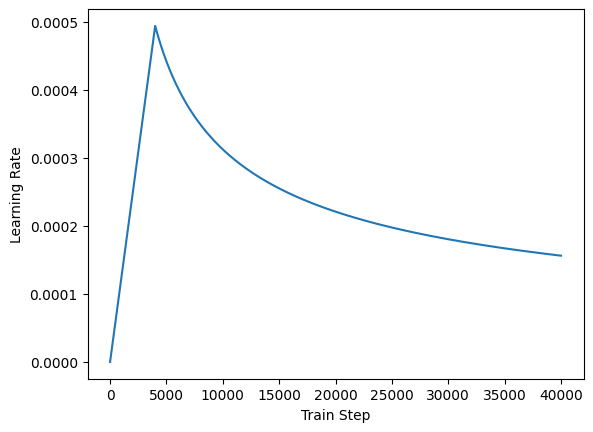

In [23]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [24]:
## call backs
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint_filepath = '/content/drive/MyDrive/NMT-Project/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

csv_logger = callbacks.CSVLogger('/content/drive/MyDrive/NMT-Project/training_log.csv' , append=True)


backup_callback = callbacks.BackupAndRestore(backup_dir="/content/drive/MyDrive/NMT-Project/backup" ,
                                             delete_checkpoint=False)

In [25]:
epochs = 30
transformer.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# tf.config.run_functions_eagerly(True)

In [29]:
history = transformer.fit(train_ds,
                epochs=epochs,
                validation_data=test_ds ,
                callbacks=[
                      early_stopping ,
                      model_checkpoint_callback ,
                      csv_logger ,
                      backup_callback ] )

Epoch 1/30
1407/1407 [==============================] - 750s 532ms/step - loss: 6.8777 - accuracy: 0.2729 - val_loss: 6.2177 - val_accuracy: 0.3025
Epoch 2/30
1407/1407 [==============================] - 744s 529ms/step - loss: 6.0646 - accuracy: 0.3047 - val_loss: 5.7225 - val_accuracy: 0.3244
Epoch 3/30
1407/1407 [==============================] - 739s 526ms/step - loss: 5.7221 - accuracy: 0.3232 - val_loss: 5.4949 - val_accuracy: 0.3390
Epoch 4/30
1407/1407 [==============================] - 747s 531ms/step - loss: 5.4075 - accuracy: 0.3429 - val_loss: 5.2972 - val_accuracy: 0.3506
Epoch 5/30
1407/1407 [==============================] - 740s 526ms/step - loss: 5.1014 - accuracy: 0.3628 - val_loss: 5.1886 - val_accuracy: 0.3573
Epoch 6/30
1407/1407 [==============================] - 731s 520ms/step - loss: 4.8687 - accuracy: 0.3798 - val_loss: 5.1709 - val_accuracy: 0.3562
Epoch 7/30
1407/1407 [==============================] - 728s 517ms/step - loss: 4.6874 - accuracy: 0.3944 - val_

In [30]:
transformer.save('/content/drive/MyDrive/NMT-Project/V1-50k-106M.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plots saved as '/content/drive/MyDrive/NMT-Project/V1-50k-106M_trainloss.png'


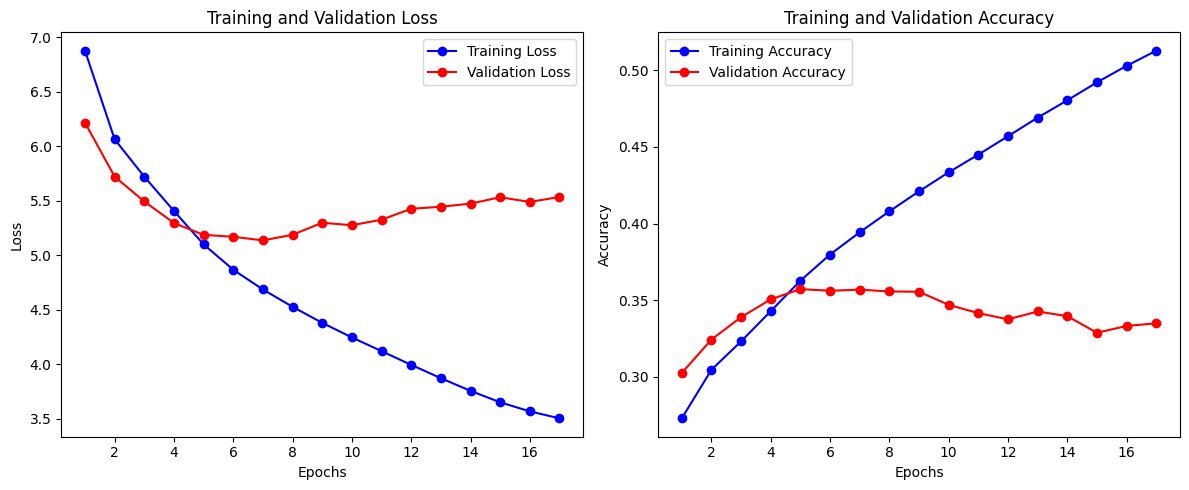

In [31]:
import os
def plot_loss_and_accuracy(history, save_dir=None, filename=None):
    # Extract the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the figure if save_dir and filename are provided
    if save_dir and filename:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path)
        print(f"Plots saved as '{save_path}'")

    plt.show()
plot_loss_and_accuracy(history ,"/content/drive/MyDrive/NMT-Project", "V1-50k-106M_trainloss.png" )

In [32]:
tam_vocab = tam_vectorization.get_vocabulary()
tam_index_lookup = dict(zip(range(len(tam_vocab)), tam_vocab))
max_decoded_sentence_length = 20

In [33]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = tam_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = tam_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

### Testing on Random Train Samples

In [35]:
# 1
sample  = random.choice(train_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  green chillies, chopped - 1 tbsp
Tamil
Ground Truth :  [start] பொடியாக நறுக்கிய பச்சை மிளகாய், கறிவேப்பிலை - தலா 1 டீஸ்பூன், [end]
Machine Translation :  [start] பச்சை மிளகாய் 1 டீஸ்பூன் [end]


In [38]:
# 2
sample  = random.choice(train_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  potassium carbonate is mainly used in the production of soap and glass.
Tamil
Ground Truth :  [start] பொட்டாசியம் கார்பனேட் ,சோப்பு மற்றும் கண்ணாடி உற்பத்தி செய்யப் பயன்படுத்தப்படுகிறது. [end]
Machine Translation :  [start] பொட்டாசியம் கால்சியம் பாஸ்பரஸ் இரும்பு மற்றும் பொட்டாசியம் [UNK] போன்ற [UNK] உள்ளன [end]


In [41]:
# 3
sample  = random.choice(train_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  these 11...
Tamil
Ground Truth :  [start] இந்த 11 கெத்து குணங்கள்தாம் . [end]
Machine Translation :  [start] இந்த 11 [end]


### Testing on Random Test samples

In [44]:
# 1
sample  = random.choice(test_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  quarters for additional mahila judge and special judges at cuddalore in cuddalore district
Tamil
Ground Truth :  [start] கடலூர் மாவட்டம் கடலூரில் ஒருங்கிணைந்த நீதிமன்ற வளாகத்தில் இருசக்கர வாகனம் நிறுத்துமிடம் அமைத்தல் [end]
Machine Translation :  [start] மாவட்ட ஆட்சியர் அலுவலக வளாகம் மற்றும் சென்னை [UNK] [end]


In [45]:
# 2
sample  = random.choice(test_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  his car window was broken .
Tamil
Ground Truth :  [start] இதில் அவரது கார் கண்ணாடிகள் உடைந்தன. [end]
Machine Translation :  [start] அந்த கார் [UNK] [UNK] [end]


In [46]:
# 3
sample  = random.choice(test_pairs)
input_sentence = sample[0]
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Ground Truth : ', sample[1])
print('Machine Translation : ' , translated )

English -  the film was loved by fans.
Tamil
Ground Truth :  [start] ரசிகர்களுக்கு படம் பிடித்துவிட்டது. [end]
Machine Translation :  [start] இந்த படம் ரசிகர்கள் மத்தியில் பெரும் வரவேற்பை பெற்றுள்ளது [end]


### Testing on custom input

In [47]:
input_sentence = "My name is Hrithik"
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Machine Translation : ' , translated )

English -  My name is Hrithik
Tamil
Machine Translation :  [start] என் பெயர் [UNK] [end]


In [55]:
input_sentence = "I will buy milk later"
translated = decode_sequence(input_sentence)
print('English - ' , input_sentence )
print('Tamil' )
print('Machine Translation : ' , translated )

English -  I will buy milk later
Tamil
Machine Translation :  [start] பின்னர் பால் [UNK] [end]


---